<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/nursery_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 保育所
- [（認可）保育所](https://catalog.data.metro.tokyo.lg.jp/dataset/t000010d0000000099/resource/f3a1b2c5-a037-4627-9166-2a4863bf3bd9)
- [児童館](https://catalog.data.metro.tokyo.lg.jp/dataset/t000010d0000000099/resource/ef6db4bc-966b-48cd-88ac-5922d413ad0b)

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [5]:
output_master_file = 'nursery_master.csv'
output_score_file = 'nursery_score.csv'

In [6]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

### 保育所

In [7]:
nursery_url = 'https://www.opendata.metro.tokyo.lg.jp/fukushihoken/R3/202110-2-1-hoikusyo.csv'
df_nursery = get_data_csv_url(nursery_url, encoding='shift-jis')
print(df_nursery.shape)

(3431, 9)


In [8]:
df_nursery['市区町村名'] = df_nursery['所在地'].str.extract('(^.*?[区市])', expand=False)
df_nursery['施設分類'] = '認可保育所'

df_nursery_master = df_nursery[
    (df_nursery['市区町村名'].notna())&
    (df_nursery['市区町村名'].str.endswith('区'))&
    (df_nursery['市区町村名'].str.len() < 5)
][['市区町村名', '施設分類', '設置', '施設名', '所在地', '緯度', '経度', '定員']].rename(columns={'施設名':'名称'}).reset_index(drop=True)
print(df_nursery_master.shape)

assert df_nursery_master['市区町村名'].nunique() == 23

(2526, 8)


### 児童館

In [9]:
childrenhouse_url = 'https://www.opendata.metro.tokyo.lg.jp/fukushihoken/R3/202110-2-2-06-zidoukan.csv'
df_childrenhouse = get_data_csv_url(childrenhouse_url, encoding='shift-jis')
print(df_childrenhouse.shape)

(587, 9)


In [10]:
df_childrenhouse['市区町村名'] = df_childrenhouse['所在地'].str.extract('(^.*?[区市])', expand=False)
df_childrenhouse['施設分類'] = '児童館'

df_childrenhouse_master = df_childrenhouse[
    (df_childrenhouse['市区町村名'].notna())&
    (df_childrenhouse['市区町村名'].str.endswith('区'))&
    (df_childrenhouse['市区町村名'].str.len() < 5)
][['市区町村名', '施設分類', '設置', '施設名', '所在地', '緯度', '経度']].rename(columns={'施設名':'名称'}).reset_index(drop=True)
print(df_childrenhouse_master.shape)

assert df_childrenhouse_master['市区町村名'].nunique() == 23

(439, 7)


### 保育所マスタ

In [11]:
df_nursery_master = pd.concat([df_nursery_master, df_childrenhouse_master]).reset_index(drop=True)
print(df_nursery_master.shape)

(2965, 8)


In [12]:
df_nursery_master.to_csv(os.path.join(DIR_NAME, output_master_file), index=False)

In [13]:
df_nursery_master

,市区町村名,施設分類,設置,名称,所在地,緯度,経度,定員
0,千代田区,認可保育所,営利法人,ほっぺるランド外神田,千代田区外神田４−８−６,35.70233,139.77260,87.0
1,千代田区,認可保育所,社福法人,外神田かなりや保育園,千代田区外神田３−６−１３,35.70255,139.76976,50.0
2,千代田区,認可保育所,区市町村,いずみこども園,千代田区神田和泉町１,35.69919,139.77597,36.0
3,千代田区,認可保育所,営利法人,あい保育園東神田,千代田区東神田２−６−５ 東神田ビル２・３階,35.69564,139.78027,63.0
4,千代田区,認可保育所,社福法人,岩本町ちとせ保育園,千代田区岩本町２−１０−１２,35.69344,139.77722,69.0
...,...,...,...,...,...,...,...,...
2960,江戸川区,児童館,区市町村,共育プラザ平井,江戸川区平井７−２１−６,35.71465,139.84042,NaN
2961,江戸川区,児童館,区市町村,共育プラザ小岩,江戸川区北小岩２−１４−１７,35.73995,139.88454,NaN
2962,江戸川区,児童館,区市町村,共育プラザ南小岩,江戸川区南小岩４−５−８,35.72095,139.88564,NaN
2963,江戸川区,児童館,区市町村,共育プラザ南篠崎,江戸川区南篠崎町３−１２−８,35.69662,139.89914,NaN


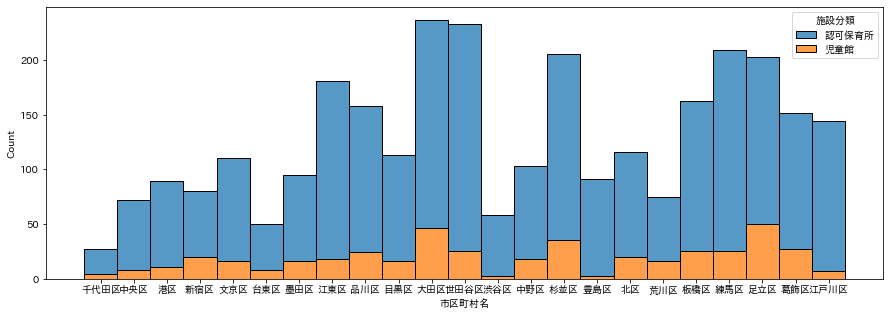

In [14]:
plt.figure(figsize=(15, 5))
sns.histplot(df_nursery_master, x='市区町村名', hue='施設分類', multiple='stack')
plt.show()

### 人口マスタ

In [15]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_pop_master.shape)

(2921, 6)


In [16]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [17]:
%%time
# 一番近い施設の距離
df_pop_master['保育園(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '認可保育所', 'min')
# 1km以内の施設の数
df_pop_master['保育園(数)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '認可保育所', 'count', 1)

# 一番近い施設の距離
df_pop_master['児童館(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '児童館', 'min')
# 2km以内の施設の数
df_pop_master['児童館(数)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '児童館', 'count', 2)

CPU times: user 6min 42s, sys: 1.29 s, total: 6min 43s
Wall time: 6min 49s


In [18]:
print(df_pop_master.shape)
df_pop_master.head()

(2921, 10)


,地域ID,市区町村名,町名,町丁目,緯度,経度,保育園(最近傍距離),保育園(数),児童館(最近傍距離),児童館(数)
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,0.747610,3,1.223562,4
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,0.841154,1,1.588228,3
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,0.611528,1,1.570712,4
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,0.324671,3,1.352763,5
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,0.306243,4,0.973485,5


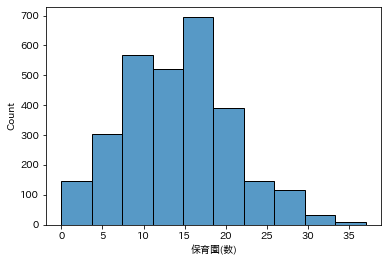

In [19]:
sns.histplot(df_pop_master['保育園(数)'], bins=10)
plt.show()

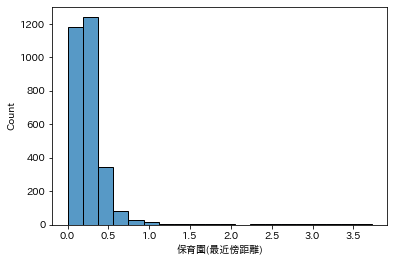

In [20]:
sns.histplot(df_pop_master['保育園(最近傍距離)'], bins=20)
plt.show()

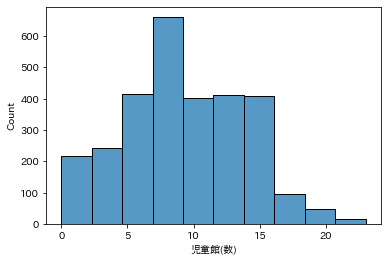

In [21]:
sns.histplot(df_pop_master['児童館(数)'], bins=10)
plt.show()

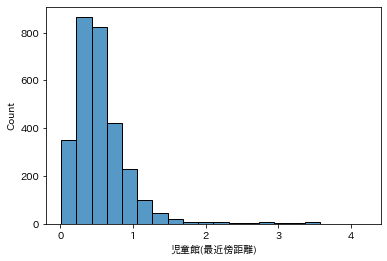

In [22]:
sns.histplot(df_pop_master['児童館(最近傍距離)'], bins=20)
plt.show()

In [23]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

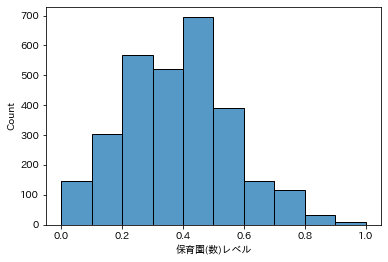

In [37]:
df_pop_master['保育園(数)レベル'] = normalize_score(df_pop_master['保育園(数)'], outlier=False)
sns.histplot(df_pop_master['保育園(数)レベル'], bins=10)
plt.show()

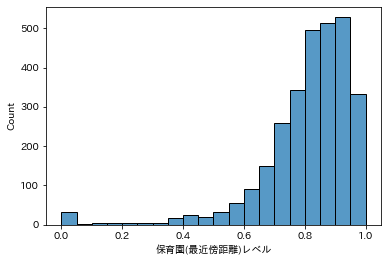

In [38]:
df_pop_master['保育園(最近傍距離)レベル'] = normalize_score(df_pop_master['保育園(最近傍距離)'], high=False)
sns.histplot(df_pop_master['保育園(最近傍距離)レベル'], bins=20)
plt.show()

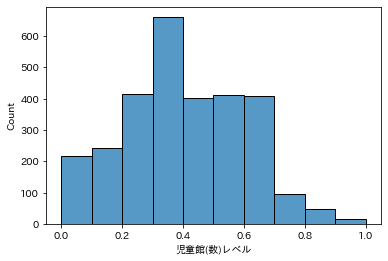

In [39]:
df_pop_master['児童館(数)レベル'] = normalize_score(df_pop_master['児童館(数)'], outlier=False)
sns.histplot(df_pop_master['児童館(数)レベル'], bins=10)
plt.show()

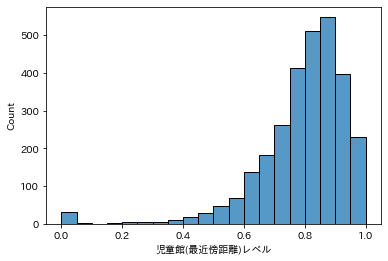

In [40]:
df_pop_master['児童館(最近傍距離)レベル'] = normalize_score(df_pop_master['児童館(最近傍距離)'], high=False)
sns.histplot(df_pop_master['児童館(最近傍距離)レベル'], bins=20)
plt.show()

In [41]:
score_list = [
    df_pop_master['保育園(最近傍距離)レベル'] * 1.0,
    df_pop_master['保育園(数)レベル'] * 0.5,
    df_pop_master['児童館(最近傍距離)レベル'] * 0.4,
    df_pop_master['児童館(数)レベル'] * 0.3,
]
df_pop_master['_保育園スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_pop_master['保育園スコア'] = rank_score(df_pop_master['_保育園スコア'])

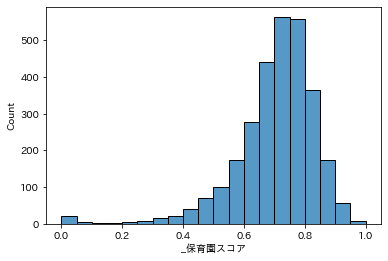

In [42]:
sns.histplot(df_pop_master['_保育園スコア'], bins=20)
plt.show()

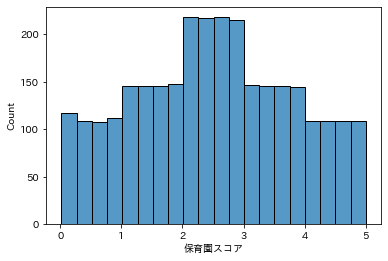

In [43]:
sns.histplot(df_pop_master['保育園スコア'], bins=20)
plt.show()

In [44]:
df_pop_master[['地域ID', '市区町村名', '町丁目', '保育園(最近傍距離)', '保育園(数)', '児童館(最近傍距離)', '児童館(数)', '保育園スコア']]\
    .to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

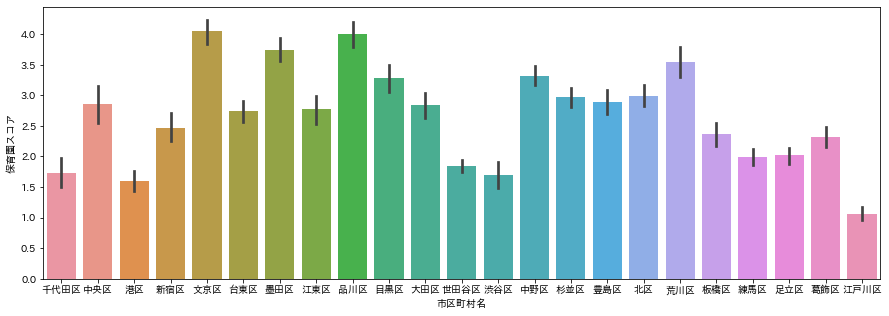

In [45]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y='保育園スコア', data=df_pop_master)
plt.show()

In [46]:
df_library_level = df_pop_master.copy()
df_library_level['rank'] = df_library_level.groupby('町名')['保育園スコア'].transform('rank', ascending=False)
df_library_level = df_library_level[df_library_level['rank'] == 1].sort_values('保育園スコア', ascending=False)[
    ['市区町村名', '町名', '町丁目', '保育園スコア', '_保育園スコア', '保育園(最近傍距離)', '保育園(数)', '児童館(最近傍距離)', '児童館(数)']
].reset_index(drop=True)
print(df_library_level.shape)

(698, 9)


In [47]:
df_library_level.head(20)

,市区町村名,町名,町丁目,保育園スコア,_保育園スコア,保育園(最近傍距離),保育園(数),児童館(最近傍距離),児童館(数)
0,品川区,豊町,豊町５丁目,5.000000,1.000000,0.082020,31,0.168118,23
1,品川区,東中延,東中延２丁目,4.997711,0.995234,0.037886,31,0.037886,18
2,品川区,戸越,戸越６丁目,4.993134,0.966072,0.178183,35,0.116917,19
3,江東区,森下,森下３丁目,4.990846,0.958373,0.010684,34,0.099574,9
4,文京区,千石,千石３丁目,4.986268,0.953254,0.096463,33,0.129314,14
5,品川区,西大井,西大井６丁目,4.983980,0.951901,0.100857,25,0.100857,22
6,文京区,本駒込,本駒込３丁目,4.981691,0.951171,0.034140,26,0.034140,16
7,目黒区,中央町,中央町２丁目,4.977114,0.945346,0.090528,30,0.090528,15
8,品川区,西中延,西中延３丁目,4.974825,0.945188,0.047800,24,0.047800,18
9,品川区,二葉,二葉１丁目,4.972537,0.943391,0.037485,26,0.374534,19


In [48]:
df_library_level.tail(20)

,市区町村名,町名,町丁目,保育園スコア,_保育園スコア,保育園(最近傍距離),保育園(数),児童館(最近傍距離),児童館(数)
678,世田谷区,玉堤,玉堤２丁目,0.535530,0.520889,0.214175,3,1.454040,1
679,江戸川区,南葛西,南葛西６丁目,0.501202,0.512100,0.094615,8,3.194937,0
680,千代田区,神田錦町,神田錦町１丁目,0.450853,0.498149,0.409772,4,1.145844,5
681,江戸川区,臨海町,臨海町２丁目,0.389061,0.479024,0.160125,7,2.524411,0
682,江戸川区,上篠崎,上篠崎４丁目,0.377618,0.476252,0.463776,9,1.321215,2
683,足立区,古千谷,古千谷２丁目,0.354732,0.469908,0.627583,3,0.627583,9
684,江戸川区,北篠崎,北篠崎１丁目,0.315826,0.456233,0.511514,5,0.917912,1
685,江東区,新砂,新砂１丁目,0.297517,0.446781,0.653698,11,0.969571,3
686,千代田区,永田町,永田町２丁目,0.281497,0.441451,0.637925,5,0.699388,4
687,江東区,青海,青海１丁目,0.272342,0.431462,0.574889,1,0.574889,1
